<a href="https://colab.research.google.com/github/Elman295/Maximum-Classifier-Discrepancy-for-Unsupervised-Domain-Adaptation/blob/main/Maximum_Classifier_Discrepancy_for_UDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch import nn

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

#`Data`

In [36]:
tfms = transforms.Compose([
    transforms.Resize(size = (28,28)),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.5, std = 0.5)
])

In [37]:
MNIST_train = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = tfms
)

MNIST_test = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = tfms
)

USPS_train = datasets.USPS(
    root = "data",
    train = True,
    download = True,
    transform = tfms
)

USPS_test = datasets.USPS(
    root = "data",
    train = False,
    download = True,
    transform = tfms
)

In [38]:
target_train_dl = DataLoader(dataset = MNIST_train, batch_size = 128, shuffle = True)
target_test_dl = DataLoader(dataset = MNIST_test, batch_size = 128, shuffle = False)

source_train_dl = DataLoader(dataset=USPS_train, batch_size = 128, shuffle = True)
source_test_dl = DataLoader(dataset = USPS_test, batch_size=128, shuffle = False)

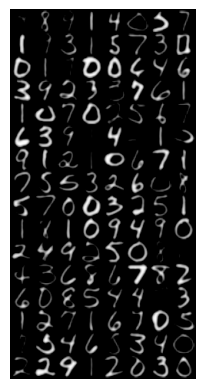

In [39]:
image, label = next(iter(source_train_dl))
outs = torchvision.utils.make_grid(image)

plt.imshow(outs.permute(1,2,0))
plt.axis("off")
plt.show()

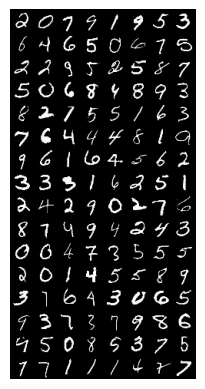

In [40]:
image, label = next(iter(target_train_dl))
outs = torchvision.utils.make_grid(image)

plt.imshow(outs.permute(1,2,0))
plt.axis("off")
plt.show()

#`Functions`

In [41]:
def discrepancy_loss(f1,f2):
  return torch.mean(torch.abs(F.softmax(f1) - F.softmax(f2)))

In [42]:
loss_ce = nn.CrossEntropyLoss()

#`Models`

In [77]:
class Generator(nn.Module):
    """LeNet encoder model for ADDA."""

    def __init__(self):
      super(Generator, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
      self.bn1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 48, kernel_size=5, stride=1)
      self.bn2 = nn.BatchNorm2d(48)

    def forward(self, x):
        x = torch.mean(x,1).view(x.size()[0],1,x.size()[2],x.size()[3])
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), stride=2, kernel_size=2, dilation=(1, 1))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), stride=2, kernel_size=2, dilation=(1, 1))
        #print(x.size())
        x = x.view(x.size(0), 48*4*4)
        return x

In [78]:
class Classifier(nn.Module):
    def __init__(self, prob=0.5):
          super(Classifier, self).__init__()
          self.fc1 = nn.Linear(48*4*4, 100)
          self.bn1_fc = nn.BatchNorm1d(100)
          self.fc2 = nn.Linear(100, 100)
          self.bn2_fc = nn.BatchNorm1d(100)
          self.fc3 = nn.Linear(100, 10)
          self.bn_fc3 = nn.BatchNorm1d(10)
          self.prob = prob

    def set_lambda(self, lambd):
        self.lambd = lambd
    def forward(self, x):
        x = F.dropout(x, training=self.training, p=self.prob)
        x = F.relu(self.bn1_fc(self.fc1(x)))
        x = F.dropout(x, training=self.training, p=self.prob)
        x = F.relu(self.bn2_fc(self.fc2(x)))
        x = F.dropout(x, training=self.training, p=self.prob)
        x = self.fc3(x)
        return x

In [79]:
G = Generator().to(device)
F1 = Classifier().to(device)
F2 = Classifier().to(device)

In [80]:
for p in F1.parameters():
  print(p)

Parameter containing:
tensor([[ 0.0147, -0.0016,  0.0207,  ...,  0.0063, -0.0187,  0.0065],
        [ 0.0163,  0.0319,  0.0028,  ..., -0.0116, -0.0239,  0.0020],
        [ 0.0130, -0.0094,  0.0325,  ..., -0.0225, -0.0356,  0.0353],
        ...,
        [ 0.0178,  0.0134,  0.0233,  ...,  0.0154, -0.0330, -0.0044],
        [-0.0179, -0.0338,  0.0273,  ..., -0.0184, -0.0275,  0.0222],
        [ 0.0103,  0.0067, -0.0339,  ...,  0.0155,  0.0165, -0.0016]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.0164, -0.0175, -0.0196,  0.0227, -0.0321,  0.0179,  0.0060, -0.0102,
        -0.0253, -0.0054,  0.0248,  0.0131, -0.0033,  0.0187,  0.0184, -0.0200,
        -0.0240,  0.0197,  0.0277, -0.0097, -0.0185,  0.0114,  0.0190, -0.0042,
        -0.0073,  0.0041,  0.0074,  0.0243, -0.0326,  0.0193, -0.0044,  0.0346,
         0.0208,  0.0283,  0.0278, -0.0027,  0.0237, -0.0079, -0.0122, -0.0340,
         0.0267, -0.0248,  0.0052,  0.0340,  0.0022,  0.0257, -0.0021,  0.0345

In [81]:
for p in F2.parameters():
  print(p)

Parameter containing:
tensor([[ 0.0315,  0.0034, -0.0247,  ...,  0.0257, -0.0151,  0.0126],
        [ 0.0010, -0.0278,  0.0175,  ...,  0.0067, -0.0300,  0.0071],
        [ 0.0143, -0.0197,  0.0092,  ..., -0.0232,  0.0085, -0.0197],
        ...,
        [ 0.0085, -0.0240, -0.0256,  ..., -0.0301, -0.0196, -0.0313],
        [ 0.0107,  0.0074,  0.0021,  ..., -0.0165,  0.0081, -0.0118],
        [-0.0308, -0.0043,  0.0066,  ..., -0.0210,  0.0267,  0.0240]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-0.0325,  0.0288, -0.0358,  0.0271,  0.0083, -0.0160, -0.0237,  0.0239,
        -0.0152,  0.0340,  0.0329, -0.0196, -0.0159,  0.0108, -0.0326,  0.0079,
         0.0142,  0.0106,  0.0345,  0.0274, -0.0071,  0.0276, -0.0184,  0.0328,
         0.0011,  0.0221, -0.0316, -0.0088,  0.0117,  0.0119,  0.0026, -0.0342,
         0.0128,  0.0161, -0.0348,  0.0233,  0.0270,  0.0205,  0.0016,  0.0053,
         0.0203, -0.0309,  0.0238, -0.0094,  0.0281, -0.0063, -0.0178, -0.0032

In [82]:
x = torch.rand(size = (32,1,28,28)).to(device)
g = G(x)
f1 = F1(g)
f2 = F2(g)

print(f1 == f2)
print(f1.shape)

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, Fal

#`Optimizers`

In [83]:
G_opt = torch.optim.Adam(params = G.parameters(), lr =  1e-4)
F1_opt = torch.optim.Adam(params = F1.parameters(), lr =  1e-4)
F2_opt = torch.optim.Adam(params = F2.parameters(), lr =  1e-4)

#`Train`

In [84]:
def train(data_s, data_t, G, F1, F2, loss_ce, discrepancy_loss, G_opt, F1_opt, F2_opt, N):
  G.train()
  F1.train()
  F2.train()

  size = len(data_s.dataset)

  for b, ((x_s,y_s),(x_t,_)) in enumerate(zip(data_s, data_t)):

    x_s, y_s, x_t = x_s.to(device), y_s.to(device), x_t.to(device)

    # stepA

    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    fs_A = G(x_s)
    y1_s_A = F1(fs_A)
    y2_s_A = F2(fs_A)

    loss_1_A = loss_ce(y1_s_A, y_s)
    loss_2_A = loss_ce(y2_s_A, y_s)
    lossA = loss_1_A + loss_2_A

    lossA.backward()

    G_opt.step()
    F1_opt.step()
    F2_opt.step()


    # stepB


    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    fs_B = G(x_s)
    y1_s_B = F1(fs_B)
    y2_s_B = F2(fs_B)
    loss_1_B = loss_ce(y1_s_B, y_s)
    loss_2_B = loss_ce(y2_s_B, y_s)
    loss_ce_B = loss_1_B + loss_2_B

    ft_B = G(x_t)
    y1_t_B = F1(ft_B)
    y2_t_B = F2(ft_B)
    loss_adv = discrepancy_loss(y1_t_B, y2_t_B)

    lossB = loss_ce_B - loss_adv

    lossB.backward()
    F1_opt.step()
    F2_opt.step()

    G_opt.zero_grad()
    F1_opt.zero_grad()
    F2_opt.zero_grad()

    # stepC

    for n in range(N):
      ft_C = G(x_t)
      y1_t_C = F1(ft_C)
      y2_t_C = F2(ft_C)
      lossC = discrepancy_loss(y1_t_C, y2_t_C)
      lossC.backward()
      G_opt.step()

      G_opt.zero_grad()
      F1_opt.zero_grad()
      F2_opt.zero_grad()


  if b % 100 == 0:
    print(f"lossA:{lossA.item()} lossB:{lossB.item()} lossC:{lossC.item()}")

#`Test`

In [85]:
def test(data, G, F1, F2, loss_ce):

  G.eval()
  F1.eval()
  F2.eval()

  size = len(data.dataset)
  num_batch = len(data)

  test_acc_1, test_loss_1 = 0,0
  test_acc_2, test_loss_2 = 0,0

  with torch.no_grad():
    for x,y in data:
      x,y = x.to(device), y.to(device)

      f = G(x)
      y1 = F1(f)
      y2 = F2(f)
      test_loss_1 += loss_ce(y1,y).item()
      test_loss_2 += loss_ce(y2,y).item()
      test_acc_1 += (y1.argmax(1) == y).type(torch.float).sum().item()
      test_acc_2 += (y2.argmax(1) == y).type(torch.float).sum().item()


    test_loss_1 /= num_batch
    test_loss_2 /= num_batch

    test_acc_1 /= size
    test_acc_2 /= size

    print(f"F1 loss : {test_loss_1} F1 accuracy: {test_acc_1 * 100}")
    print(f"F2 loss : {test_loss_2} F2 accuracy: {test_acc_2 * 100}")

#`Training`

In [87]:
for epoch in range(50):
  print(f"epoch : {epoch+1}=-=-=-=-=-=-")
  train(source_train_dl, target_train_dl, G, F1, F2, loss_ce, discrepancy_loss, G_opt, F1_opt, F2_opt, N = 1)
  print(f"target:")
  test(target_train_dl, G, F1, F2, loss_ce)
  print("source:")
  test(source_test_dl, G, F1, F2, loss_ce)

epoch : 1=-=-=-=-=-=-


<ipython-input-41-a642ba8e7794>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.mean(torch.abs(F.softmax(f1) - F.softmax(f2)))


target:
F1 loss : 0.7591913528025531 F1 accuracy: 79.86999999999999
F2 loss : 0.7272143202549868 F2 accuracy: 80.91666666666667
source:
F1 loss : 0.2110858461819589 F1 accuracy: 94.07075236671649
F2 loss : 0.2760541448369622 F2 accuracy: 92.2272047832586
epoch : 2=-=-=-=-=-=-
target:
F1 loss : 0.7247184549313365 F1 accuracy: 80.37166666666667
F2 loss : 0.7391985602724527 F2 accuracy: 80.74
source:
F1 loss : 0.20230366429314017 F1 accuracy: 94.31988041853513
F2 loss : 0.25785470474511385 F2 accuracy: 92.77528649725959
epoch : 3=-=-=-=-=-=-
target:
F1 loss : 0.728640644725706 F1 accuracy: 80.33166666666666
F2 loss : 0.7141201564752216 F2 accuracy: 81.33500000000001
source:
F1 loss : 0.19863644149154425 F1 accuracy: 94.56900847035377
F2 loss : 0.25293842470273376 F2 accuracy: 92.9745889387145
epoch : 4=-=-=-=-=-=-
target:
F1 loss : 0.7140553253673033 F1 accuracy: 80.68666666666667
F2 loss : 0.7121471418246531 F2 accuracy: 81.85833333333333
source:
F1 loss : 0.20461676269769669 F1 accuracy